Explicit FDM only for one option price

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from math import sqrt, log, exp
from scipy import stats, linalg, interpolate
import numpy as np
import scipy
import random

from IPython.core.display import display, HTML
import json

3D plot class

In [42]:
def plot3D(X, Y, Z, height=600, xlabel = "Sigma", ylabel = "K", zlabel = "Option Price", initialCamera = None):
    options = {
        "width": "100%",
        "style": "surface",
        "showPerspective": True,
        "showGrid": True,
        "showShadow": False,
        "keepAspectRatio": True,
        "height": str(height) + "px"
    }
    if initialCamera:
        options["cameraPosition"] = initialCamera
    data = [ {"x": X[y,x], "y": Y[y,x], "z": Z[y,x]} for y in range(X.shape[0]) for x in range(X.shape[1]) ]
    visCode = r"""
       <link href="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.css" type="text/css" rel="stylesheet" />
       <script src="https://cdnjs.cloudflare.com/ajax/libs/vis/4.21.0/vis.min.js"></script>
       <div id="pos" style="top:0px;left:0px;position:absolute;"></div>
       <div id="visualization"></div>
       <script type="text/javascript">
        var data = new vis.DataSet();
        data.add(""" + json.dumps(data) + """);
        var options = """ + json.dumps(options) + """;
        var container = document.getElementById("visualization");
        var graph3d = new vis.Graph3d(container, data, options);
        graph3d.on("cameraPositionChange", function(evt)
        {
            elem = document.getElementById("pos");
            elem.innerHTML = "H: " + evt.horizontal + "<br>V: " + evt.vertical + "<br>D: " + evt.distance;
        });
       </script>
    """
    htmlCode = "<iframe srcdoc='"+visCode+"' width='100%' height='" + str(height) + "px' style='border:0;' scrolling='no'> </iframe>"
    display(HTML(htmlCode))

Use BS model to check the correction 

In [43]:
def get_bs_price(s, sigma, t, r, k):
    y1 = (np.log(s/k) + (r + 0.5*(sigma**2))* t) / (sigma * np.sqrt(t))
    y2 = (np.log(s/k) + (r - 0.5*(sigma**2)) * t) / (sigma * np.sqrt(t))
    cdf1 = scipy.stats.norm.cdf(y1)
    cdf2 = scipy.stats.norm.cdf(y2)
    price = s * cdf1 - np.exp(-r * t) * k * cdf2
    return price

option parameters

In [44]:
# 0 : Call / 1: Put
CallPut = 0;

DaysPerYear = 365
Days = 120
T = 0.3
S_0 = 105
K = 100
r = 0.1
sigma = 0.2

In [45]:
print(get_bs_price(S_0,sigma,T,r,K))

9.48320417651


In [54]:
# Parameters of FDM.
TGrid = 500
SGrid = 100
Smax = 2 * S_0
Tmax = Days/DaysPerYear
KGrid = np.linspace(0, Smax, SGrid)
T = np.linspace(0, Tmax, TGrid)
dt = T[1] - T[0]
dS = KGrid[1] - KGrid[0]
prices = np.zeros((SGrid, TGrid))

In [55]:
## Black-Scholes (explicit FDM Simulation).
if CallPut == 0:    
    prices[:,TGrid - 1] = np.maximum(KGrid - K, 0)
    prices[SGrid - 1,:] = (KGrid[SGrid - 1] - K) * np.exp((r) * T)
    prices[1,:] = 0
elif CallPut == 1:
    prices[:,TGrid - 1] = np.maximum(K - KGrid, 0)
    prices[SGrid - 1,:] = 0
    prices[1,:] = (K - KGrid[SGrid - 1]) * np.exp((r) * T)
    
#X, Y = np.meshgrid(np.linspace(0,100,100),np.linspace(0,100,100))

#Z = prices
#plot3D(X, Y, Z)

In [56]:
a = 0.5 * dt * (sigma**2 * KGrid/(dS**2) - (r)/dS)* KGrid
b = 1 - dt * (sigma**2 * KGrid**2/(dS**2) + (r))
c = 0.5 * dt * (sigma**2 * KGrid/(dS**2) + (r)/dS)* KGrid

run time check

In [57]:
%%time
for n in range (100):
    for j in range(TGrid - 2, 0, -1) :
        for i in range(1, SGrid - 2) :
            prices[i,j] = a[i]*prices[i-1, j+1] + b[i]*prices[i, j+1] + c[i]*prices[i+1, j+1]

CPU times: user 9.01 s, sys: 35.9 ms, total: 9.04 s
Wall time: 9.23 s


plot how this method find the result

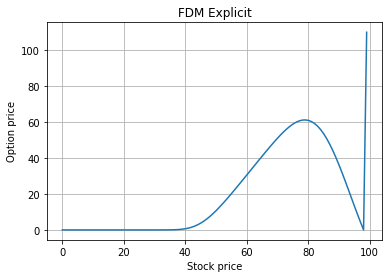

9.84875528442369


In [58]:
plt.plot(np.arange(0, 100, 1),prices[:,1])
plt.title('FDM Explicit')
plt.ylabel('Option price')
plt.xlabel('Stock price')
plt.grid(True)
plt.show()
expFDMPrice = interpolate.interp1d(KGrid, prices[:,1])(S_0)#find the price when the stock price is S_0
print(expFDMPrice)

plot the value on the whole mesh to see it clearely 

In [28]:
X, Y = np.meshgrid(np.linspace(0,100,100),np.linspace(0,100,100))
Z = prices
plot3D(X, Y, Z)

25 Feb 2018